In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import numpy as np 
import tensorflow as tf 
from tensorflow.keras import Model 
from tensorflow.keras.layers import Dense
from tensorflow.keras import layers
from scipy.special import kl_div


In [2]:
import tensorflow_ranking as tfr 

In [3]:
import time 

## Updated - April Cross-Validation

In [4]:
import seaborn as sns
x = np.linspace(-4, 4, 100)
tencent_blue = (0,0.3215686274509804,0.8509803921568627)
tencent_orange = (0.9333333333333333, 0.49411764705882355, 0.2784313725490196)


# Calculate y-values for the standard normal density curve
y_standard_normal = (1 / np.sqrt(2 * np.pi)) * np.exp(-0.5 * x**2)

In [7]:
def aggregate_probability_exposure_examination(probs_matrix, exposure_matrix): 
    aggregate_probs = np.mean(probs_matrix, axis = 0)
    exposure_probs = np.mean(exposure_matrix, axis = 0)
    ## Euclidean distance 
    euc_dist = np.linalg.norm(aggregate_probs - exposure_probs)
    ## NDCG LOSS 
    y_true = tf.ragged.constant(exposure_matrix)
    y_pred = tf.ragged.constant(probs_matrix)
    loss_NDCG = tfr.keras.losses.ApproxNDCGLoss(ragged=True)
    NDCG_loss_result = loss_NDCG(y_true, y_pred).numpy()
    return euc_dist, aggregate_probs, exposure_probs, NDCG_loss_result
def mySoftMax(arr):
    num = np.exp(arr)
    denom = np.sum(num)
    return num/denom


def naive_est(res):
    treat_res = [elm[0] for elm in res[0]]
    control_res = [elm[1] for elm in res[0]]
    return np.mean(treat_res) - np.mean(control_res)


def dim_est(obs_T, obs_C):
    n1,n0 = len(obs_T), len(obs_C)
    return np.mean(obs_T) -np.mean(obs_C), np.sqrt(np.var(obs_T)/n1 + np.var(obs_C) / n0)


def point_est(all_treat_array, all_control_array):
    mus_T, mus_C  = all_treat_array[:, 11:21], all_control_array[:,11:21]
    p_T, p_C  = all_treat_array[:, 21:], all_control_array[:,21:]
    return np.mean(np.sum((mus_T * (p_T - p_C)), axis = 1 ))


def naive_dim_estimate(vector_T, vector_C):
    return np.mean(vector_T) - np.mean(vector_C), np.var(vector_T)/len(vector_T) + np.var(vector_C) / len(vector_C)

def debias_estimator(Hfuncs, debias_terms):
    score_functions = Hfuncs - debias_terms 
    undebiased_estimator = np.mean(Hfuncs)
    debiased_estimator = np.mean(score_functions)
    variance_estimator = np.mean((score_functions - debiased_estimator)**2) /len(score_functions)
    return debiased_estimator, variance_estimator, undebiased_estimator 

def debias_estimator_new(Hfuncs, debias_terms,tau_hat):
    psi_functions = Hfuncs - debias_terms 
    undebiased_estimator = np.mean(Hfuncs)
    debiased_estimator = np.mean(psi_functions)
    variance_estimator = np.sum((psi_functions - tau_hat)**2) /len(psi_functions)
    return debiased_estimator, variance_estimator, undebiased_estimator 


def undebias_estimator_new(Hfuncs,tau_hat):
    psi_functions = Hfuncs 
    undebiased_estimator = np.mean(Hfuncs)
    variance_estimator = np.sum((psi_functions - tau_hat)**2) /len(psi_functions)
    
    return undebiased_estimator, variance_estimator 


def is_invertible(matrix):
    return np.linalg.det(matrix) != 0

In [113]:
## True Model 

class MyModel_True:
    def __init__(self, k, num_treats,promo_ratio):

        self.k = k
        self.promo_ratio = promo_ratio
        self.num_treats = num_treats

    def predict(self,inputs):
        Q_input = inputs.shape[0]
        split_structure =  [1]+ [1] + [1] * self.num_treats + [1]
        splitted_elements = tf.split(inputs, split_structure, axis=2)
        X_utility =  np.squeeze(np.array(splitted_elements[1]), axis=2)
        X_goodbads = np.squeeze(np.array(splitted_elements[0]), axis = 2)
        X_utility = X_utility + X_goodbads
        W_matrix =  np.squeeze(np.array(splitted_elements[2]), axis =2 )

        final_score_matrix =  W_matrix * self.promo_ratio  + X_utility

        ## First element of each row 
        first_elm = X_utility[:,0]
        minus_matrix = first_elm.reshape((len(first_elm),1))@np.ones((1,K))
        final_score_matrix_normalized = final_score_matrix - minus_matrix
        ## Correct exposure probability 
        X_logit = np.apply_along_axis(logistic_row, axis=1, arr=final_score_matrix_normalized)
    
        expose_indices = np.argmax(X_logit, axis = 1)
        inddds = np.array(list(np.arange(K)) * Q_input).reshape(Q_input,K)
        exposure_matrix = np.array([inddds[i,:] == expose_indices[i] for i in range(Q_input)])

        ## Outcome model  
        
        ## First: a true outcome model of Exponential 
        outcome_potential = np.random.normal(size=(Q_input, K)) +  X_utility + W_matrix
        pred_out = np.sum(exposure_matrix * outcome_potential, axis = 1 )
        pred_out = pred_out.reshape(pred_out.shape[0], 1 )
        return np.concatenate([X_logit, pred_out], axis = 1 )
## True Model 

class MyModel_Random:
    def __init__(self, k, num_treats,promo_ratio):

        self.k = k
        self.promo_ratio = promo_ratio
        self.num_treats = num_treats

    def predict(self,inputs):
        output_shape = np.array(input_3d_test_treat.shape)[:2]
        array = np.random.rand(output_shape[0],output_shape[1])
        # Compute the sum of each row
        row_sums = np.sum(array, axis=1)

        # Reshape the row sums to make them compatible for broadcasting
        row_sums = row_sums.reshape(-1, 1)

        normalized_array = array / row_sums

        return normalized_array

In [114]:
## Number of videos 
J = 20 
## Consideration set size 
K = 5 
k=5
## Generate some queries along with the recommendation model 
Q = 800


def permute_treatment_dict(J):
    perm_dict = {}
    for j in range(J):
        perm_dict[j] = np.random.choice([True,False], 1)
    return perm_dict

In [115]:

## True Exposure Model and Data Generating Process 
def logistic_row(row):
    return np.exp(row) / np.sum(np.exp(row))





# I. deterministic: 
# selected_indices = np.argmax(X_logit, axis = 1)
# II. random choice for exposure 

def DGP(promo_rat, K,Q, J):
    ## Generate a utility score for each viewer and video pair
    utility_score_matrix = np.exp(np.random.normal(size=(Q,J)))
    good_bad_dict = {} 
    treatment_dict = {} 
    utility_score = {} 
    for j in range(J):
        good_bad_dict[j] = np.random.choice([True,False], 1)
        treatment_dict[j] = np.random.choice([True,False], 1)
        utility_score[j] = np.random.uniform()
    X_goodbads = []
    X_utility = []
    W_matrix = []
    query_matrix = []
    promo_ratio = promo_rat
    for each_query in range(Q):
        ## Form the consideration set 
        selected_indices = np.random.choice(np.arange(J), K, replace= False)
        query_matrix += [selected_indices]
        X_goodbads = np.append(X_goodbads,[good_bad_dict[ind] for ind in selected_indices])
        X_utility = np.append(X_utility, [utility_score_matrix[each_query, ind] for ind in selected_indices])
        W_matrix = np.append(W_matrix, [treatment_dict[ind] for ind in selected_indices])
    X_goodbads = X_goodbads.reshape(Q, K)
    X_utility = X_utility.reshape(Q, K)
    X_utility = X_utility + X_goodbads 
    W_matrix = W_matrix.reshape(Q,K)
    final_score_matrix =  W_matrix * promo_ratio  + X_utility

    X_logit = np.apply_along_axis(logistic_row, axis=1, arr=final_score_matrix)
    expose_indices = np.array([np.random.choice(np.arange(K), size = 1, p = X_logit[i,:]) for i in range(Q)])
    inddds = np.array(list(np.arange(K)) * Q).reshape(Q,K)
    exposure_matrix = np.array([inddds[i,:] == expose_indices[i] for i in range(Q)])

    ## Outcome model  
    ## First: a true outcome model of Exponential 
    outcome_potential = np.random.normal(size=(Q, K)) +  X_utility + W_matrix

    return query_matrix,X_goodbads,X_utility,W_matrix, exposure_matrix, outcome_potential



In [137]:
def DGP_with_counter_factual(promo_rat, K,Q, J):
    ## Generate a utility score for each viewer and video pair
    utility_score_matrix = np.exp(np.random.normal(size=(Q,J)))
    good_bad_dict = {} 
    treatment_dict = {} 
    utility_score = {} 
    for j in range(J):
        good_bad_dict[j] = np.random.choice([True,False], 1)
        treatment_dict[j] = np.random.choice([True,False], 1)
        utility_score[j] = np.random.uniform()
    X_goodbads = []
    X_utility = []
    W_matrix = []
    query_matrix = []
    promo_ratio = promo_rat
    for each_query in range(Q):
        ## Form the consideration set 
        selected_indices = np.random.choice(np.arange(J), K, replace= False)
        query_matrix += [selected_indices]
        X_goodbads = np.append(X_goodbads,[good_bad_dict[ind] for ind in selected_indices])
        X_utility = np.append(X_utility, [utility_score_matrix[each_query, ind] for ind in selected_indices])
        W_matrix = np.append(W_matrix, [treatment_dict[ind] for ind in selected_indices])
    X_goodbads = X_goodbads.reshape(Q, K)
    X_utility = X_utility.reshape(Q, K)
    X_uitlity = X_utility + X_goodbads 
    W_matrix = W_matrix.reshape(Q,K)
    final_score_matrix = W_matrix * promo_ratio  + X_utility
    ## Add counterfactuals 
    final_score_treat =  promo_ratio   + X_utility
    final_score_control = X_utility 
    
    
    X_logit = np.apply_along_axis(logistic_row, axis=1, arr=final_score_matrix)
    ## Add counterfactuals 
    X_logit_treat = np.apply_along_axis(logistic_row, axis=1, arr=final_score_treat)
    X_logit_control = np.apply_along_axis(logistic_row, axis=1, arr=final_score_control)
    
    
    expose_indices = np.array([np.random.choice(np.arange(K), size = 1, p = X_logit[i,:]) for i in range(Q)])
    inddds = np.array(list(np.arange(K)) * Q).reshape(Q,K)
    exposure_matrix = np.array([inddds[i,:] == expose_indices[i] for i in range(Q)])
    
    expose_indices_treat = np.array([np.random.choice(np.arange(K), size = 1, p = X_logit_treat[i,:]) for i in range(Q)])
    exposure_matrix_treat = np.array([inddds[i,:] == expose_indices_treat[i] for i in range(Q)])
    
    expose_indices_control = np.array([np.random.choice(np.arange(K), size = 1, p = X_logit_control[i,:]) for i in range(Q)])
    exposure_matrix_control = np.array([inddds[i,:] == expose_indices_control[i] for i in range(Q)])

    ## Outcome model  
    ## First: a true outcome model of Exponential 
    outcome_potential = np.random.normal(size=(Q, K)) +  X_utility + W_matrix

    return query_matrix,X_goodbads,X_utility,W_matrix, exposure_matrix, outcome_potential, exposure_matrix_treat, exposure_matrix_control 



In [152]:
## Helper function for cross validation
def generate_indices(n, K):
    ## Split original sample of size n into K sets 
    indices = np.linspace(0, n, K+1, dtype=int)
    return list(zip(indices[:-1], indices[1:]))


def train_test_split(input_data, all_inds, kth_test):
    
    training_ind = [all_inds[i] for i in range(len(all_inds)) if i != kth_test]
    test_start, test_end = all_inds[kth_test]
    if not tf.is_tensor(input_data):
        training_data = np.concatenate([input_data[elm[0]:elm[1]] for elm in training_ind])
    else:
        
        training_data = tf.concat([input_data[elm[0]:elm[1]] for elm in training_ind], axis = 0)
    testing_data = input_data[test_start:test_end]
    return training_data, testing_data 



In [153]:
uplift_ratio = 0.5

In [154]:
MC = 1
for mc in range(MC):
    query_matrix,X_goodbads,X_utility,W_matrix, exposure_matrix, outcome_potential, exposure_matrix_treat, exposure_matrix_control = DGP_with_counter_factual(uplift_ratio, K,Q,J)
    outcome_t = np.sum(outcome_potential * exposure_matrix_treat, axis = 1 )
    outcome_c = np.sum(outcome_potential * exposure_matrix_control, axis = 1 )
    
    

In [155]:
np.mean(outcome_t)

4.058977652107595

In [156]:
np.mean(outcome_t)

4.058977652107595

In [157]:
np.mean(outcome_c)

3.9263524456503522

In [158]:
exposure_matrix_treat.astype(float) - exposure_matrix_control.astype(float)

array([[ 0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  1., -1.,  0.],
       [ 1., -1.,  0.,  0.,  0.],
       ...,
       [ 0.,  0.,  0.,  0.,  0.],
       [ 0., -1.,  1.,  0.,  0.],
       [ 0.,  1., -1.,  0.,  0.]])

In [159]:
1 + 1 

2

Start K = 5, Q = 800, J = 30
0
9/9 [==============================] - 0s 589us/step
Fail for inversion
9/9 [==============================] - 0s 432us/step
20
9/9 [==============================] - 0s 454us/step
40
9/9 [==============================] - 0s 627us/step
Fail for inversion
9/9 [==============================] - 0s 434us/step
60
9/9 [==============================] - 0s 501us/step
80
9/9 [==============================] - 0s 457us/step


/var/folders/8t/rt03lktd63z_37vmxz10hy0w0000gn/T/ipykernel_32861/145466283.py:399: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(np.array(debias_B_true) /  np.sqrt(np.array(debias_var_B_true)/(int(Q))) , shade = True,color=tencent_blue,label = "Ours(debiased)",alpha=0.1)
/var/folders/8t/rt03lktd63z_37vmxz10hy0w0000gn/T/ipykernel_32861/145466283.py:400: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(np.array(undebias_B_true) /  np.sqrt(np.array(undebias_var_B_true)/(int(Q))) , shade = True,color='red',label = "Ours(undebiased)",alpha=0.1)
/var/folders/8t/rt03lktd63z_37vmxz10hy0w0000gn/T/ipykernel_32861/145466283.py:401: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14

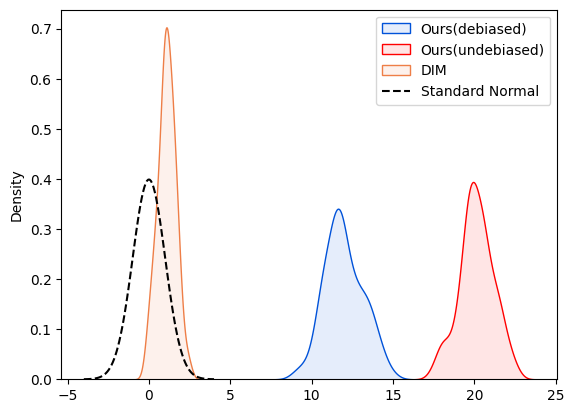

In [160]:
dim_B, dim_var_B= [],[]
debias_B_true, debias_var_B_true = [],[] 
undebias_B_true, debias_var_old_B_true = [],[]
truth= []
undebias_var_B_true = []
## Number of iterations of DGP
B = 100
## Number of videos 
JQ_sizes = [(50,1000), (100,1000), (200, 1000)]
training_ratio = 0.4

num_features = 2 

## Consideration set size 
Ks = [5,10,20]

JQ_sizes = [(30,800)]
Ks = [5]


for (J, Q) in JQ_sizes:
    for K in Ks:
        print("Start K = {}, Q = {}, J = {}".format(str(K), str(Q), str(J)))
        dim_B, dim_var_B= [],[]
        debias_B_true, debias_var_B_true = [],[] 
        undebias_B_true, debias_var_old_B_true = [],[]
        truth= []


        ## True Outcome Model test 
        L = 1
        ith_treat = 0
        M = 100
        groupNames = [0,1]
        k = K
        n_folds = 3
        for b in range(B):
            if b % 20 == 0:
                print(b)
            ## DGP and data pre-processing 
            query_matrix,X_goodbads,X_utility,W_matrix, exposure_matrix, outcome_potential= DGP(uplift_ratio, K,Q,J)

            ## Fix in v2: add cross-fitting to the code 
            all_inds = generate_indices(np.array(query_matrix).shape[0], n_folds)
            

            ## Iterate over each fold for cross-validation. 

            hfuncs_each_fold,  debias_terms_each_fold = {},{}
            for f in range(n_folds):
                f_start, f_end = all_inds[f]
                query_train, query_test = train_test_split(np.array(query_matrix), all_inds, f)
                X_goodbads_train, X_goodbads_test =  train_test_split(X_goodbads, all_inds, f) 
                X_utility_train, X_utility_test =  train_test_split(X_utility, all_inds, f)  
                W_matrix_train, W_matrix_test = train_test_split(W_matrix, all_inds, f) 
                observed_queries_treatment = np.sum(exposure_matrix * W_matrix, axis = 1 )
                observed_outcome = np.sum(outcome_potential * exposure_matrix, axis = 1 )

                T, C = observed_outcome[observed_queries_treatment == groupNames[ith_treat + 1 ]] , observed_outcome[observed_queries_treatment == 0]  
                exposure_matrix_train,exposure_matrix_test =train_test_split(exposure_matrix, all_inds, f) 
                outcome_matrix = exposure_matrix * outcome_potential
                outcome_matrix = np.sum(outcome_matrix, axis = 1 ).reshape(outcome_matrix.shape[0],1)

                observed_outcome_train, observed_outcome_test = train_test_split(observed_outcome, all_inds, f) 
                outcome_matrix_train, outcome_matrix_test = train_test_split(outcome_matrix, all_inds, f) 
                outcome_potential_train, outcome_potential_test = train_test_split(outcome_potential, all_inds, f)  
                inputs_3d_train = tf.stack([X_goodbads_train,X_utility_train, W_matrix_train, X_utility_train ], axis = -1)
                inputs_3d_test = tf.stack([X_goodbads_test,X_utility_test, W_matrix_test, X_utility_test], axis = -1)





                input_3d_test_treat = tf.stack([X_goodbads_test,X_utility_test, np.ones(W_matrix_test.shape), X_utility_test], axis = -1)
                input_3d_test_control = tf.stack([X_goodbads_test,X_utility_test, np.zeros(W_matrix_test.shape), X_utility_test], axis = -1)
                output_3d_train = tf.concat([tf.cast(exposure_matrix_train, dtype=float),outcome_matrix_train], axis = 1)
                output_3d_test = tf.concat([tf.cast(exposure_matrix_test, dtype=float),outcome_matrix_test ], axis = 1)

                exposure_indicator_array = exposure_matrix_test


                ## Get treatment indicator matrix
                w_dict = {}

                for l in range(L):
                    w_dict[l] = tf.convert_to_tensor(W_matrix == groupNames[l+1], dtype = float)

                training_num = int(W_matrix.shape[0] * training_ratio)
                testing_num = W_matrix.shape[0] - training_num


                w_all_treat = tf.convert_to_tensor(np.array([[1] * k for _ in range(W_matrix.shape[0])],dtype='float32'))
                w_all_control = tf.convert_to_tensor(np.array([[0] * k for _ in range(W_matrix.shape[0])],dtype='float32'))

                inputs_all_treat_3d = tf.stack([X_goodbads,X_utility] + [w_all_treat if l == ith_treat else w_all_control for l in range(L)] +[ X_utility], axis = 2)
                inputs_all_control_3d = tf.stack([X_goodbads,X_utility] + [w_all_control if l == ith_treat else w_all_control for l in range(L)] +[ X_utility ], axis = 2)
                inputs_all_treat_3d = tf.cast(inputs_all_treat_3d, dtype = 'float32')
                inputs_all_control_3d = tf.cast(inputs_all_control_3d, dtype = 'float32')

                ## All other all_treated 
                inputs_all_treat_3d_dict = {} 
                for l in range(L):
                    inputs_all_treat_3d_l = tf.stack([X_goodbads,X_utility] + [w_all_treat if l == v else w_all_control for v in range(L)] +[ X_utility ], axis = 2)
                    #inputs_all_treat_3d_l = tf.stack([x_basebid, x_sort_score, x_bid,x_ecpm, x_cvr] + [w_all_treat if v == l else w_all_control for v in range(L)] + [x_cvr], axis = 2)
                    inputs_all_treat_3d_dict[l] = tf.cast(inputs_all_treat_3d_l, dtype = 'float32')

                exposure_indicator_outcome_train, exposure_indicator_outcome_test = outcome_matrix_train, outcome_matrix_test
                inputs_all_treat_3d_test = input_3d_test_treat
                inputs_all_control_3d_test = input_3d_test_control
                is_selected_indicator_train,is_selected_indicator_test = exposure_matrix_train,exposure_matrix_test

                treat_control_dict = {} 
                for l in range(L):

                    
                    inputs_3d_train_l,inputs_3d_test_l= train_test_split(inputs_all_treat_3d_dict[l], all_inds, f) 

                    treat_control_dict[l] = {'train':inputs_3d_train_l, 'test': inputs_3d_test_l}

                myModelMultiple = MyModel_True(K, L, uplift_ratio)
                myModelMultiple_random = MyModel_Random(K, L, uplift_ratio)
                # myModelMultiple.compile(loss=custom_loss,optimizer=tf.keras.optimizers.legacy.Adam())
                # myModelMultiple.fit(input_3d_train,output_3d_train , epochs=10, verbose=False)
                exposure_indicator_array = is_selected_indicator_test
                treatment_indicator_array = 1 * (np.array(w_dict[ith_treat])[f_start:f_end,:])

                res_tempt = np.array(myModelMultiple.predict(inputs_all_treat_3d_test)) - np.array(myModelMultiple.predict(inputs_all_control_3d_test))


                pred_H_new = np.array(myModelMultiple.predict(inputs_all_treat_3d_test)) - np.array(myModelMultiple.predict(inputs_all_control_3d_test))
                model_pred_H = np.array(myModelMultiple.predict(inputs_3d_test))
                model_pred_all_treat = myModelMultiple.predict(inputs_all_treat_3d_test)
                model_pred_all_control = myModelMultiple.predict(inputs_all_control_3d_test)
                all_treat_array, all_control_array = np.array(model_pred_all_treat), np.array(model_pred_all_control)

                ## All other counterfactuals 
                counterfactual_pred_dict = {} 
                for l in range(L):
                    model_pred_all_l = myModelMultiple.predict(treat_control_dict[l]['test'])
                    counterfactual_pred_dict[l] = model_pred_all_l

                ## Outcome - prediction model 
                indicator_bool = tf.cast(is_selected_indicator_train, dtype=tf.bool)
                selected_elements = tf.boolean_mask(inputs_3d_train[:,:,:num_features], indicator_bool)

                input_to_outcomemodel_train = tf.reshape(selected_elements, (inputs_3d_train.shape[0], num_features))
                # Define your base model
                base_model = tf.keras.Sequential()
                base_model.add(layers.Dense(1, input_shape=(num_features,)))

                # Compile the model
                base_model.compile(optimizer='sgd', loss='mean_squared_error')
                base_model.fit(input_to_outcomemodel_train,output_3d_train[:, K],epochs=50, verbose=False)
                # Now define a new model for prediction
                model_for_prediction = tf.keras.Sequential()
                model_for_prediction.add(layers.TimeDistributed(base_model, input_shape=(K, num_features)))
                predictions = model_for_prediction.predict(inputs_3d_test[:,:,:num_features])
                # Remove the third dimension of size 1
                numpy_array_pred = np.squeeze(predictions, axis=2)

                mus_T, mus_C  = numpy_array_pred,numpy_array_pred
                p_T, p_C  = all_treat_array[:, :k], all_control_array[:,:k]
                rewards_array = observed_outcome_test
                rewards_array = rewards_array.reshape(rewards_array.shape[0],1)
                Ey1,Ey0 = np.sum(mus_T * p_T, axis = 1), np.sum(mus_C * p_C, axis = 1)
                pv1,pv0 = np.sum(exposure_indicator_array * p_T, axis = 1), np.sum(exposure_indicator_array * p_C, axis = 1)

                pv_given_uvw = p_T * treatment_indicator_array + p_C * (1 - treatment_indicator_array)


                p_realized = model_pred_H[:,:K]



                ## 1. COMPUTE THE GRADIENT OF LOSSS  
                ## FIX: change to realized outcome 
                #dl1dtheta0 = pv_given_uvw - exposure_indicator_array
                dl1dtheta0 = p_realized - exposure_indicator_array
                dl1dtheta0 = dl1dtheta0[:, 1:] 


                ## FIX: iterate over all L 
                dl1dthetal_dict = {} 
                for l in range(L):
                    treatment_indicator_array_l = w_dict[l][f_start:f_end, :]
                    dl1dthetal_dict[l] = treatment_indicator_array_l *  (p_realized - exposure_indicator_array)
                dl2dmu = exposure_indicator_array * (mus_T -rewards_array)
                gradient_vector_l = np.concatenate([dl1dtheta0]+[dl1dthetal_dict[l] for l in range(L)] +[dl2dmu], axis =1 )





                ## 2. COMPUTE  THE GRADIENT OF H FUNCTION
                dHdtheta0 = p_T * (mus_T - Ey1.reshape(mus_T.shape[0],1)) - p_C * (mus_C - Ey0.reshape(mus_C.shape[0],1))
                dHdtheta0 = dHdtheta0[:, 1:]



                ## FIX: iterate over each l 
                dHdthetal_dict = {} 
                for l in range(L):

                    p_T_thetal = counterfactual_pred_dict[l][:,:k]
                    Eyl = np.sum(mus_T * p_T_thetal, axis = 1)
                    dHdthetal_dict[l] = p_T_thetal * (mus_T - Eyl.reshape(mus_T.shape[0],1))
                    ## 0 for the groups that are not the target treatment group 
                    if l != ith_treat:
                        dHdthetal_dict[l] = 0 * (p_T_thetal * (mus_T - Eyl.reshape(mus_T.shape[0],1)))

                #dHdthetal = p_T * (mus_T - Ey1.reshape(mus_T.shape[0],1))
                dHdmu = p_T - p_C
                #gradient_vector_H = np.concatenate([dHdtheta0,dHdthetal,dHdmu], axis =1 )

                ## FIX: iterate over all l 
                gradient_vector_H = np.concatenate([dHdtheta0]+[dHdthetal_dict[l] for l in range(L)]+[dHdmu], axis =1 )
                ## Gradient over all other treatments 





                ## 3. FIND THE EXPECTATION OF HESSIAN MATRIX 



                Hessian_all = np.zeros((inputs_3d_test.shape[0],(L+2) * K - 1,  (L+2) * K - 1))

                montecarlo_expected_probability = np.zeros(exposure_indicator_array.shape)

                selected_indicator_dict  = {}
                assignment_pd_dict = {} 
                dmu_dict = {} 




                for m in range(M):
                    treat_dict_m = permute_treatment_dict(J)





                M = 500
                for m in range(M):
                    w_dict_m = {} 
                    treat_dict_m = permute_treatment_dict(J)
                    W_matrix_m = []
                    for i in range(np.array(query_matrix).shape[0]):
                        ## Form the consideration set 
                        each_query=np.array(query_matrix)[i,:]
                        W_matrix_m = np.append(W_matrix_m, [[treat_dict_m[ind] for ind in each_query]])

                    W_matrix_m = W_matrix_m.reshape(np.array(query_matrix).shape)



                    for l in range(L):
                        w_dict_m[l] = tf.convert_to_tensor(W_matrix_m == groupNames[l + 1], dtype = float)


                    inputs_3d_m = tf.stack([X_goodbads,X_utility]+  [w_dict_m[l] for l in range(L)] +[X_goodbads], axis = -1)
                    inputs_3d_test_m = inputs_3d_m[f_start:f_end,:]
                    model_pred_m = np.array(myModelMultiple.predict(inputs_3d_test_m))[:,:k]
                    outer_product_pv1pv2 = np.array([np.outer(row_[1:], row_[1:]) for row_ in model_pred_m])
                    outer_product_treatment_indicator = np.array([np.outer(row_, row_) for row_ in model_pred_m])
                    outer_product_pv1_one_minus_pv2 = np.array([np.outer(row_, 1-row_) for row_ in model_pred_m])
                    p_treat = 1/(L+1) 

                    is_selected_indicator_test = np.array(exposure_matrix[f_start:f_end,:])
                    selected_indicator_dict[m] = is_selected_indicator_test 
                    d2l2dtheta0 = - np.array([np.outer(row_, row_) for row_ in model_pred_m])

                    ## FIX: Iterate over l 
                    d2l2dthetal_dict = {}
                    for l in range(L):
                        ## K by K 

                        w_m_l = np.array(w_dict_m[l][f_start:f_end,:])

                        ## Off-diagonal terms 
                        # d2l2dtheta1 =  np.array([np.outer(row_, row_) for row_ in w_m_l]) * np.array([np.outer(row_, row_) for row_ in model_pred_m])
                        d2l2dtheta1 = - p_treat * p_treat * np.array([np.outer(row_, row_) for row_ in model_pred_m])
                        ## Modify diagonal terms
                        for i in range(d2l2dtheta1.shape[0]):
                            treat_indicator_i = w_m_l[i,:]
                            probs_i = model_pred_m[i,:]
                            # np.fill_diagonal(d2l2dtheta1[i],treat_indicator_i * probs_i * (1-probs_i))
                            np.fill_diagonal(d2l2dtheta1[i], p_treat * probs_i * (1-probs_i))
                        d2l2dthetal_dict[l] = d2l2dtheta1



                    ## FIX: iterate over all l1, l2 
                    d2ldthetal1dthetal2 = {} 
                    for l in range(L):
                        w_m_l = np.array(w_dict_m[l][f_start:f_end,:])
                        ## Off-diagonal terms 
                        #d2l2dtheta0dtheta1 = - np.multiply(w_m_l[:,np.newaxis], np.array([np.outer(row_, row_) for row_ in model_pred_m]))
                        d2l2dtheta0dtheta1 = - p_treat * np.array([np.outer(row_, row_) for row_ in model_pred_m])
                        for i in range(d2l2dtheta0dtheta1.shape[0]):
                            treat_indicator_i = w_m_l[i,:]
                            p_1minusp_i = model_pred_m[i,:] * (1 - model_pred_m[i,:])
                            #np.fill_diagonal(d2l2dtheta0dtheta1[i], treat_indicator_i * p_1minusp_i)
                            np.fill_diagonal(d2l2dtheta0dtheta1[i], p_treat * p_1minusp_i)

                        ## NOTE: -1 to indicate the baseline theta 
                        d2ldthetal1dthetal2[(-1,l)] = d2l2dtheta0dtheta1[:,1:,:]
                        d2ldthetal1dthetal2[(l,-1)] = np.transpose(d2l2dtheta0dtheta1[:,1:,:], (0,2,1))
                        for l_prime in range(L):
                            if l != l_prime: 
                                #w_m_l = np.array(w_dict_m[l][training_num:,:])
                                #w_m_l_prime = np.array(w_dict_m[l_prime][training_num:,:])
                                #indicator_outer = np.array([np.outer(w_m_l[i,:], w_m_l_prime[i,:]) for i in range(w_m_l.shape[0])])

                                #d2l2dthetal1dthetal2 = -  indicator_outer * np.array([np.outer(row_, row_) for row_ in model_pred_m])
                                d2l2dthetal1dthetal2 = -  p_treat * p_treat * np.array([np.outer(row_, row_) for row_ in model_pred_m])
                                d2ldthetal1dthetal2[(l,l_prime)]  = d2l2dthetal1dthetal2
                                d2ldthetal1dthetal2[(l_prime,l)]  = np.transpose(d2l2dthetal1dthetal2, (0,2,1))
                            else:
                                d2ldthetal1dthetal2[(l,l)] = d2l2dthetal_dict[l]


                    d2l2dmu = np.zeros(d2l2dtheta1.shape)

                    # treatment_indicator_array_m = 
                    for i in range(d2l2dmu.shape[0]):
                        #p_1minusp_i = (1 - model_pred_m[i,:]) * (1 - model_pred_m[i,:])
                        p_1minusp_i = model_pred_m[i,:] * (1 - model_pred_m[i,:])
                        # treatment_i = treatment_indicator_array[i,:]
                        # exposure_i = is_selected_indicator_test[i,:]
                        np.fill_diagonal(d2l2dtheta0[i], p_1minusp_i)
                        np.fill_diagonal(d2l2dmu[i], model_pred_m[i,:])



                    d2l2dtheta0 = d2l2dtheta0[:,1:, 1:]
                    # d2l2dtheta01_k_m_1_by_k = d2l2dtheta01[:, 1:,:]
                    # d2l2dtheta10_k_by_k_m_1 = d2l2dtheta01[:, :,1:]
                    Hessian_first_row = np.concatenate([d2l2dtheta0] + [d2ldthetal1dthetal2[(-1, l)] for l in range(L)] + [np.zeros((d2l2dtheta0.shape[0], K-1, K))], axis =2)

                    ## 1 to L + 1 row 
                    Hessian_middle_dict = {}
                    for l in range(L):
                        row_l = np.concatenate([d2ldthetal1dthetal2[(l, -1)]] + [d2ldthetal1dthetal2[(l, l_prime)] for l_prime in range(L)] +[np.zeros((d2l2dtheta0.shape[0], K, K))], axis =2)

                        Hessian_middle_dict[l] = row_l                                                                           


                    Hessian_third_row = np.concatenate((np.zeros((d2l2dtheta0.shape[0], K, K  * (L + 1 ) - 1 )), d2l2dmu), axis =2)

                    Hessian = np.concatenate([Hessian_first_row] + [Hessian_middle_dict[l] for l in range(L)] + [Hessian_third_row], axis = 1 )

                    dmu_dict[m] = d2l2dmu

                    Hessian_all = Hessian_all + Hessian

                Hessian_final = Hessian_all / M
                count_finite = 0
                score_funcs = np.zeros(len(Hessian_final))
                for i in range(len(Hessian_final)):
                    if is_invertible(Hessian_final[i]):
                        try:
                            score_funcs[i] = gradient_vector_H[i]@np.linalg.inv(Hessian_final[i])@gradient_vector_l[i]
                            count_finite += 1 
                        except: 
                            print("Fail for inversion")
                outs_1 = res_tempt[score_funcs !=0,K]


                ## END OF FOR LOOP FOR EACH ITERATION OVER CROSS FITTING
                hfuncs_f, debias_term_f = outs_1,score_funcs[score_funcs!=0]
                # debias_point_f,  debias_var_f, undebiased_point_f  = debias_estimator(outs_1, score_funcs[score_funcs!=0])
                # debias_point_each_fold += [debias_point_f]  
                # debias_var_each_fold += [debias_var_f]
                # undebiased_point_each_fold += [undebiased_point_f]
                hfuncs_each_fold[f] =hfuncs_f
                debias_terms_each_fold[f] = debias_term_f

            tau_hat_undebias = np.mean([ np.mean(hfuncs_each_fold[f])for f in range(n_folds)])
            tau_hat_debias = np.mean([ np.mean(hfuncs_each_fold[f] - debias_terms_each_fold[f])  for f in range(n_folds)])
            debias_point = tau_hat_debias
            debias_var = np.mean([debias_estimator_new(hfuncs_each_fold[f] ,debias_terms_each_fold[f], tau_hat_debias)[1] for f in range(n_folds)])
            undebias_var = np.mean([undebias_estimator_new(hfuncs_each_fold[f] ,tau_hat_undebias)[1] for f in range(n_folds)])
            undebias_point = tau_hat_undebias
            dim_point, dim_var = dim_est(T, C)
            dim_B += [dim_point]
            dim_var_B += [dim_var]
            debias_B_true += [debias_point]
            debias_var_B_true += [debias_var]
            undebias_B_true += [undebias_point]
            undebias_var_B_true += [undebias_var]

        result_df = pd.DataFrame({"debias_point": debias_B_true, "debias_var":debias_var_B_true, "dim": dim_B, 
                                 "dim_var":dim_var_B, "undebias_point": undebias_B_true, "J" : J,"Q": Q, "K":K })
        result_df.to_csv("result2405new/new_{}_synthetic_aa_j{}q{}k{}_100_{}.csv".format(str(int(time.time())),str(J), str(Q), str(K), str(uplift_ratio).replace('.','')))
        plt.figure() 
        sns.kdeplot(np.array(debias_B_true) /  np.sqrt(np.array(debias_var_B_true)/(int(Q))) , shade = True,color=tencent_blue,label = "Ours(debiased)",alpha=0.1)
        sns.kdeplot(np.array(undebias_B_true) /  np.sqrt(np.array(undebias_var_B_true)/(int(Q))) , shade = True,color='red',label = "Ours(undebiased)",alpha=0.1)
        sns.kdeplot(np.array(dim_B) / np.sqrt(np.array(dim_var_B)), shade = True,color=tencent_orange,label = "DIM",alpha=0.1)
        plt.plot(x, y_standard_normal, color='black', label="Standard Normal", ls='--')
        plt.legend()
        
        plt.savefig("result2405new/new_{}_synthetic_aa_j{}q{}k{}_density{}.png".format(str(int(time.time())), str(J), str(Q), str(K), str(uplift_ratio).replace('.','')))

In [171]:
result_df = pd.DataFrame({"debias_point": np.array(debias_B_true)-1, "debias_var":np.array(debias_var_B_true)-1, "dim": np.array(dim_B)-1, 
                            "dim_var":dim_var_B, "undebias_point": undebias_B_true, "undebias_var" : undebias_var_B_true, "J" : J,"Q": Q, "K":K })

In [172]:
result_df.to_csv("result2405new/aa_bias.csv")

/var/folders/8t/rt03lktd63z_37vmxz10hy0w0000gn/T/ipykernel_32861/1136559431.py:2: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot((np.array(debias_B_true) - 1) /  np.sqrt(np.array(debias_var_B_true)/(int(Q))) , shade = True,color=tencent_blue,label = "Ours(debiased)",alpha=0.1)
/var/folders/8t/rt03lktd63z_37vmxz10hy0w0000gn/T/ipykernel_32861/1136559431.py:3: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot((np.array(undebias_B_true)-1) /  np.sqrt(np.array(undebias_var_B_true)/(int(Q))) , shade = True,color='red',label = "Ours(undebiased)",alpha=0.1)
/var/folders/8t/rt03lktd63z_37vmxz10hy0w0000gn/T/ipykernel_32861/1136559431.py:4: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seabor

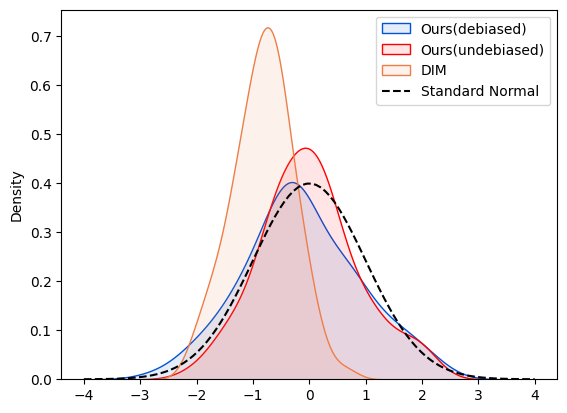

In [165]:
plt.figure() 
sns.kdeplot((np.array(debias_B_true) - 1) /  np.sqrt(np.array(debias_var_B_true)/(int(Q))) , shade = True,color=tencent_blue,label = "Ours(debiased)",alpha=0.1)
sns.kdeplot((np.array(undebias_B_true)-1) /  np.sqrt(np.array(undebias_var_B_true)/(int(Q))) , shade = True,color='red',label = "Ours(undebiased)",alpha=0.1)
sns.kdeplot((np.array(dim_B)-1) / np.sqrt(np.array(dim_var_B)), shade = True,color=tencent_orange,label = "DIM",alpha=0.1)
plt.plot(x, y_standard_normal, color='black', label="Standard Normal", ls='--')
plt.legend()

plt.savefig("result2405new/AB_plot_new_{}_synthetic_aa_j{}q{}k{}_density{}.png".format(str(int(time.time())), str(J), str(Q), str(K), str(uplift_ratio).replace('.','')))

In [166]:
np.mean(undebias_B_true)

0.9998973562297789

In [167]:
np.mean(debias_B_true)

0.9889744371163391

In [ ]:
plt.figure() 
sns.kdeplot((np.array(debias_B_true) - 1) /  np.sqrt(np.array(debias_var_B_true)/(int(Q))) , shade = True,color=tencent_blue,label = "Ours(debiased)",alpha=0.1)
sns.kdeplot((np.array(undebias_B_true)-1) /  np.sqrt(np.array(undebias_var_B_true)/(int(Q))) , shade = True,color='red',label = "Ours(undebiased)",alpha=0.1)
sns.kdeplot((np.array(dim_B)-1) / np.sqrt(np.array(dim_var_B)), shade = True,color=tencent_orange,label = "DIM",alpha=0.1)
plt.plot(x, y_standard_normal, color='black', label="Standard Normal", ls='--')
plt.legend()

plt.savefig("result2405new/AB_plot_new_{}_synthetic_aa_j{}q{}k{}_density{}.png".format(str(int(time.time())), str(J), str(Q), str(K), str(uplift_ratio).replace('.','')))

In [21]:
np.mean([undebias_estimator_new(hfuncs_each_fold[f] ,tau_hat_undebias)[1] for f in range(n_folds)])

2.135910608227538

In [18]:
np.sqrt(np.array(debias_var_B_true)/1000)

array([0.03933085, 0.0424891 , 0.04443004, 0.04312402, 0.0446908 ,
       0.0443037 , 0.04640344, 0.04147065, 0.04376858, 0.04620856,
       0.03929771, 0.04282472, 0.03754242, 0.04303195, 0.04262914,
       0.04111774, 0.03840048, 0.04105075, 0.04195991, 0.04525505,
       0.04003356, 0.04439367, 0.03887688, 0.04131435, 0.04249267,
       0.04066437, 0.04143187, 0.04353405, 0.04371462, 0.04307449,
       0.04282268, 0.04626568, 0.04389099, 0.04234505, 0.0409563 ,
       0.04778946, 0.04402007, 0.04246734, 0.04609795, 0.0383043 ,
       0.04760242, 0.04158091, 0.04710728, 0.04223181, 0.04509957,
       0.04298899, 0.0437782 , 0.04477155, 0.0456346 , 0.04561083,
       0.04373887, 0.04657138, 0.04024379, 0.04579814, 0.04229292,
       0.0420206 , 0.03991841, 0.04828655, 0.04322153, 0.04482983,
       0.04226   , 0.04494336, 0.04454485, 0.0409877 , 0.04144452,
       0.04454716, 0.04598581, 0.04640789, 0.04144408, 0.04366758,
       0.04545103, 0.04256248, 0.04519621, 0.04063017, 0.04295

/opt/.jupyter/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  """Entry point for launching an IPython kernel.
/opt/.jupyter/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  """Entry point for launching an IPython kernel.
/opt/.jupyter/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  
/opt/.jupyter/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  


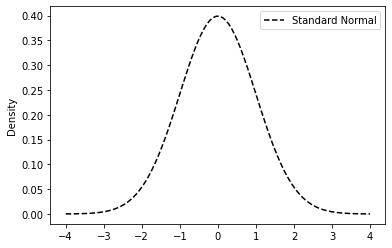

In [24]:
sns.kdeplot(np.array(debias_B_true) /  np.sqrt(np.array(debias_var_B_true)/(int(Q/n_folds))) , shade = True,color=tencent_blue,label = "Ours",alpha=0.1)
sns.kdeplot(np.array(dim_B) / np.sqrt(np.array(dim_var_B)), shade = True,color=tencent_orange,label = "DIM",alpha=0.1)
plt.plot(x, y_standard_normal, color='black', label="Standard Normal", ls='--')
plt.legend()

In [16]:
## Alternatively, restore results from files 
result_pd = pd.read_csv("result2405new/synthetic_aa_j50q1000k5_100.csv")
debias_B_true = np.array(result_pd['debias_point'])
debias_var_B_true = np.array(result_pd['debias_var'])
dim_B =  np.array(result_pd['dim'])
dim_var_B =  np.array(result_pd['dim_var'])
undebias_B_true =  np.array(result_pd['undebias_point'])
Q = result_pd['Q'].values[0]


In [45]:
print("The mean of debias estimator: ")
np.mean(debias_B_true)

The mean of debias estimator: 


0.00534794431700648

In [46]:
print("The mean of undebais estimator: ")
np.mean(undebias_B_true)

The mean of undebais estimator: 


0.006304546398725099

In [47]:
print("The mean of difference in means estimator: ")
np.mean(dim_B)

The mean of difference in means estimator: 


-0.0020664674767521475

In [49]:
np.mean(np.array(debias_B_true) /  np.sqrt(np.array(debias_var_B_true)/(int(Q))))

0.0645356984832383

In [58]:
np.mean(undebias_B_true)

-0.013110619688956509

In [57]:
np.mean(debias_B_true)

-0.00559628461560289

In [59]:
np.mean(dim_B)

-0.06413286616691673

/opt/.jupyter/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  """Entry point for launching an IPython kernel.
/opt/.jupyter/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  
/opt/.jupyter/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  This is separate from the ipykernel package so we can avoid doing imports until


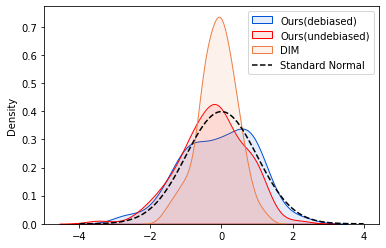

In [56]:
sns.kdeplot((np.array(debias_B_true)) /  np.sqrt(np.array(debias_var_B_true)/(int(Q))) , shade = True,color=tencent_blue,label = "Ours(debiased)",alpha=0.1)
sns.kdeplot((np.array(undebias_B_true)) /  np.sqrt(np.array(undebias_var_B_true)/(int(Q))) , shade = True,color='red',label = "Ours(undebiased)",alpha=0.1)
sns.kdeplot((np.array(dim_B)) / np.sqrt(np.array(dim_var_B)), shade = True,color=tencent_orange,label = "DIM",alpha=0.1)
plt.plot(x, y_standard_normal, color='black', label="Standard Normal", ls='--')
plt.legend()
# plt.savefig("result2404new/comparison_estimators.png")

In [43]:
1 + 1 

2

In [ ]:
# gradient_vector_H[i]@np.linalg.inv(Hessian_final[i])@gradient_vector_l[i]

In [ ]:
# np.linalg.inv(Hessian_final[i])

In [ ]:
debias_B_true

In [ ]:
is_invertible(Hessian_final[i])

In [ ]:
from scipy.special import kl_div

In [ ]:
expos_mat = exposure_matrix_test.astype(float)
probs_mat = model_pred_H[:, :K]
def bootstrap_evaluation(probs_mat, expos_mat, B = 100):
    nrows = probs_mat.shape[0]
    kl_div_list, NDCG_list = [], []
    for b in range(B):
        indices = np.random.choice(nrows, size=nrows, replace=True)
        probs_mat_b = probs_mat[indices,:]
        expos_mat_b = expos_mat[indices,:]
        
        _, agg_probs_b, agg_expos_b, NDCG_b = aggregate_probability_exposure_examination(probs_mat_b, expos_mat_b)
        kl_divergence_b = kl_div(agg_probs_b,agg_expos_b).sum()

        kl_div_list += [kl_divergence_b]
        NDCG_list += [NDCG_b]
    return kl_div_list, NDCG_list 
kl_, ndcg_ = bootstrap_evaluation(probs_mat.astype(np.float32), expos_mat.astype(np.float32))

# aggregate_probability_exposure_examination(probs_mat.astype(np.float32), expos_mat.astype(np.float32))

In [ ]:
sns.kdeplot(ndcg_)